## Import packages

In [181]:
# Data manipulation
import numpy as np
import pandas as pd
import glob, os
import time

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.ensemble import IsolationForest 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

## Preprocessing

#### Load files

In [166]:
# arkiv_B
path_arkivb = '/Users/Emil/Data/Exjobbsdata/Sandvik/Data/CSV_2018_B_Arkiv_Sekund'
all_arkivb = glob.glob(os.path.join(path_arkivb, "B1_2018_V2*.TXT")) 
df_each_arkivb = (pd.read_csv(f, sep=';', header = None, encoding = 'unicode_escape') for f in all_arkivb)
arkivb_df = pd.concat(df_each_arkivb, ignore_index = True)

arkivb_df['Datetime'] = pd.to_datetime(arkivb_df[3] + ' ' + arkivb_df[4])
arkivb_df = arkivb_df.drop([3, 4], axis = 1)

In [204]:
# handelser (sep 17- jun 18)
path_handelser = '/Users/Emil/Data/Exjobbsdata/Sandvik/Data/Handelser'
all_handelser = glob.glob(os.path.join(path_handelser, "*.TXT"))

df_each_handelser = (pd.read_csv(f, sep=';', header = None, encoding = 'unicode_escape', parse_dates = [1]) for f in all_handelser)
handelser_df1 = pd.concat(df_each_handelser, ignore_index = True)
handelser_df = handelser_df1.drop([3, 4], axis=1)

In [169]:
# larm
#path_larm = '/Users/Emil/Data/Exjobbsdata/Sandvik/Data/Larm'
#all_larm = glob.glob(os.path.join(path_larm, "*.TXT"))

#df_each_larm = (pd.read_csv(f, sep=';', header = None, encoding = 'unicode_escape') for f in all_larm)
#larm_df = pd.concat(df_each_larm, ignore_index = True)

,0,1,2
0,HMI_AI._10AH_BG1041.STATUS,2017-09-01 01:48:36,Låg
1,HMI_AI._12TJM_BT1284_1.STATUS,2017-09-01 06:08:21,Låg
2,HMI_AI._12TJM_BT1284_1.STATUS,2017-09-01 07:51:42,Låg
3,HMI_AI._12TJM_BT1284_1.STATUS,2017-09-01 09:06:17,Låg
4,HMI_AI._12TJM_BT1284_1.STATUS,2017-09-01 10:21:16,Låg
5,USED_MAIN_MEM_P,2017-09-01 20:50:55,30% Ledigt
6,HMI_TEC.AV_BANDBROTT_PAR1,2017-09-02 00:49:33,Materiallarm (A)
7,HMI_SF.IO_FAULT_INPUTS,2017-09-02 06:27:09,Fel
8,HMI_SF.SUM,2017-09-02 06:27:09,Fel
9,USED_MAIN_MEM_P,2017-09-02 14:25:20,30% Ledigt


#### Pivot data

In [171]:
arkivb_pivot_df = pd.pivot_table(arkivb_df, values=0, index='Datetime', columns=2)

#### Group by time

In [173]:
arkivb_grouped_df = arkivb_pivot_df.resample("3T").mean()
arkivb_grouped_df.shape

(23521, 84)

#### Erasing if variance is zero

In [174]:
# Drop columns with zero variance (constant)
cols_without_variance = [col for col in arkivb_grouped_df.columns if (arkivb_grouped_df[col].var() == 0)]
arkivb_variance_df = arkivb_grouped_df.drop(cols_without_variance, axis=1)

# Resulting shape
arkivb_variance_df.shape

(23521, 75)

#### Handling missing values and imputing

In [177]:
# Specify acceptance percent of missing data
cut_off = 0.75

# Drop columns with missing data
arkivb_missing_df = arkivb_variance_df.dropna(thresh = cut_off*len(arkivb_variance_df.index), axis = 1)

# Impute missing values with linear function
arkivb_imputed_df = arkivb_missing_df.interpolate(axis=0)

# Resulting shape
arkivb_missing_df.shape

(23521, 26)

#### Resulting dataframe

In [178]:
arkivb_df = arkivb_imputed_df
arkivb_df.head()

2,"10AH.DRI: Drivning avhaspel, akt specifikt drag","11PAR.DRI: Drivning valspar 1, akt specifikt drag","12PAR.DRI: Drivning valspar 2, akt specifikt drag","14PH.DRI: Drivning påhaspel, akt specifikt drag","GIvare: Valsoljeflöde, skalat värde","Givare: Diametermätare avhaspel, skalat värde","Givare: Flöde från filter 1 till rentank, skalat värde","Givare: Flöde från filter 2 till rentank, skalat värde","Givare: Nivå i rentank, skalat värde","Givare: Nivå i smutstank, skalat värde",...,"Givare: Valskraft skevning par 2, skalat värde","Givare: Valsoljetryck, skalat värde","Givare:Temp valsolja, skalat värde",Par 1: Diffvalskraft,Par 1: valskraft,Par 3: Diffvalskraft,Par 3: valskraft,"Posregulator valsspalt, ärvärde","Tjockleksmätare 2 , avvikelse","Tjockleksmätare 3 , avvikelse"
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-05-21 01:00:00,0.0,0.600559,0.926163,0.878771,283.634545,185.455085,324.419512,327.753659,1.6,1.500000,...,1.982192,1.850838,30.231818,0.0,0.0,-4.9,4.9,0.0,-143.633333,-144.7
2018-05-21 01:03:00,0.0,0.635196,1.065363,0.929609,283.468142,185.251471,324.319178,327.750617,1.6,1.500000,...,1.926126,1.842697,30.223404,0.0,0.0,-4.9,4.9,0.0,-143.650000,-144.7
2018-05-21 01:06:00,0.0,0.650556,1.102222,0.970556,283.455263,185.323932,324.227027,327.780303,1.6,1.500000,...,1.895000,1.847458,30.217647,0.0,0.0,-4.9,4.9,0.0,-143.633333,-144.7
2018-05-21 01:09:00,0.0,0.658989,1.145506,0.990449,283.434951,185.386260,324.168919,327.752542,1.6,1.500000,...,1.900000,1.843182,30.209677,0.0,0.0,-4.9,4.9,0.0,-143.700000,-144.7
2018-05-21 01:12:00,0.0,0.648045,1.070391,0.967039,283.511864,185.664815,324.360294,327.891304,1.6,1.501333,...,1.681250,1.853933,30.160000,0.0,0.0,-4.9,4.9,0.0,-143.700000,-144.7


## Visualization

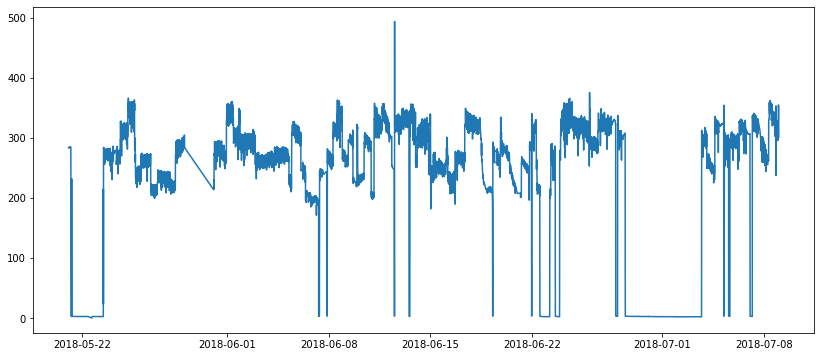

In [196]:
plt.figure(figsize=(14,6))
sns.lineplot(data = arkivb_df['GIvare: Valsoljeflöde, skalat värde'])

## Model

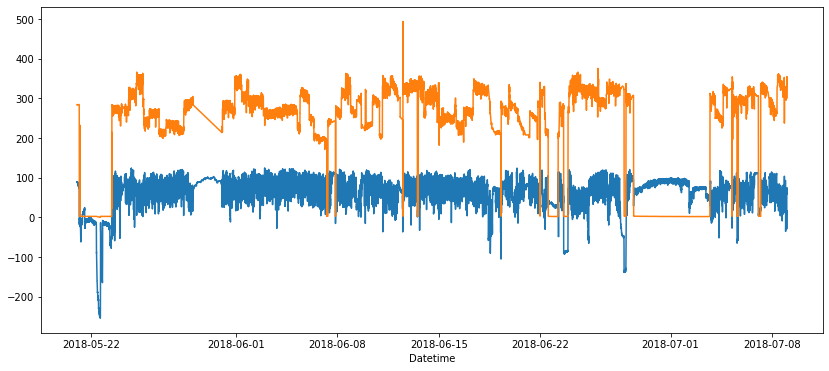

In [203]:
X = arkivb_df
if_model = IsolationForest(contamination = 'auto', behaviour="new")
if_model.fit(X)
if_score = if_model.decision_function(X)
plt.figure(figsize=(14,6))
sns.lineplot(x = X.index, y = if_score * 1000)
#sns.lineplot(data = X['GIvare: Valsoljeflöde, skalat värde'])